In [15]:
%load_ext autoreload
%autoreload 2

In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import gpplot as gpp
import anchors
from poola import core as pool

import core_functions as fns

gpp.set_aesthetics(palette='Set2')


## Functions 

In [2]:
#QC 


def get_grouped_controls(df, control_name):
    '''
    Inputs:
    1. df: guide-gene annotation df 
    2. control_name: list of string identifiers for controls 
    Outputs:
    1. grouped_genes: controls grouped into pseudogenes with
    '''
    ungrouped_df = pd.DataFrame()
    for control in control_name:
        control_condition = (df['Gene Symbol'].str.contains(control, na=False))
        control_rows = df[control_condition]
        #if all controls have same Gene Symbol
        if len(set(control_rows['Gene Symbol'])) == 1:
            ungrouped_df = df.copy()
            # Give controls unique names before grouping 
            ungrouped_df.loc[control_condition, 'Gene Symbol'] = control + control_rows['Guide'] 
    
    ungrouped_genes = ungrouped_df.dropna()

    grouped_genes = pool.group_pseudogenes(ungrouped_genes[['Guide', 'Gene Symbol']], pseudogene_size=4, gene_col='Gene Symbol', control_regex = control_name)

    #grouped_controls = pd.concat([LibA_grouped_genes, LibB_grouped_genes])

    return grouped_genes

    
def match_pseudogenes(df, guide_mapping, control_name):
    '''
    Inputs: 
    1. df: data frame to which grouped pseudogene annotations will be merged 
    2. guide_mapping: guide-gene annotation data frame
    3. control_name: list containing substrings that identify controls 
    '''
    grouped_genes = get_grouped_controls(guide_mapping, control_name)
    grouped_df = pd.merge(grouped_genes, df, on = 'Guide', how = 'outer', suffixes = ['', '_old'])
    grouped_df.loc[:,'Gene Symbol'] = grouped_df.loc[:,'Gene Symbol'].fillna(grouped_df['Gene Symbol_old'])
    grouped_df = grouped_df.drop('Gene Symbol_old', axis = 1)

    return grouped_df

In [3]:
def run_guide_residuals(lfc_df, paired_lfc_cols):
    '''
    Calls get_guide_residuals function from anchors package to calculate guide-level residual z-scores
    Input:
    1. lfc_df: data frame with log-fold changes (relative to pDNA)
    
    '''
#     paired_lfc_cols = pair_cols(lfc_df)[1] #get lfc pairs 
    modified = []
    unperturbed = []
    #reference_df: column1 = modifier condition, column2 = unperturbed column
    ref_df = pd.DataFrame(columns=['modified', 'unperturbed'])
    row = 0 #row index for reference df 
    for pair in paired_lfc_cols:
        #number of resistant pops in pair = len(pair)-1
        res_idx = 1 
        #if multiple resistant populations, iterate 
        while res_idx < len(pair): 
            ref_df.loc[row, 'modified'] = pair[res_idx]
            ref_df.loc[row, 'unperturbed'] = pair[0]
            res_idx +=1 
            row +=1
    print(ref_df)
    #input lfc_df, reference_df 
    #guide-level
    residuals_lfcs, all_model_info, model_fit_plots = anchors.get_guide_residuals(lfc_df, ref_df)
    return residuals_lfcs, all_model_info, model_fit_plots


## Data Summary

* Cell line: Calu-3
* Library: Gattinara

In [4]:
reads_all = pd.read_csv('../../Data/Reads/Hsu/Calu3_KO.txt', sep = '\t', error_bad_lines=False)

# Columns to include
# KO:
# Treatment: E-SS_D4_MOI01_r1_run1, Hv3_4_av-SS_R2_D4_run3, Iv4-And_R2_D10_run3 
# Control: B-SS_D0_r1_run1, D-SS_D0_R2_run1, F_av-And_R2_D0_Pt2_run2
treatment_cols = ['E-SS_D4_MOI01_r1_run1', 'Hv3_4_av-SS_R2_D4_run3', 'Iv4-And_R2_D10_run3']
control_cols = ['B-SS_D0_r1_run1', 'D-SS_D0_R2_run1', 'F_av-And_R2_D0_Pt2_run2']
base_cols = ['sgRNA', 'Gene', 'plasmid']


cols_to_include = base_cols + control_cols + treatment_cols
reads = reads_all[cols_to_include]
reads = reads.rename(columns={'plasmid':'pDNA'})
reads = reads.rename(columns={'Gene':'Gene Symbol'})
reads = reads.rename(columns={'sgRNA':'Guide'})
reads = match_pseudogenes(reads.copy(), reads.copy()[['Guide', 'Gene Symbol']], control_name=['Non-Targeting'])
reads

b'Skipping line 77442: expected 12 fields, saw 22\n'


,Guide,Gene Symbol,pDNA,B-SS_D0_r1_run1,D-SS_D0_R2_run1,F_av-And_R2_D0_Pt2_run2,E-SS_D4_MOI01_r1_run1,Hv3_4_av-SS_R2_D4_run3,Iv4-And_R2_D10_run3
0,43525_41331_AGATGACCACAAGTGAAAGG,MARCHF1,369.062904,496.677349,755.849269,3147.920983,466.110661,549.165957,557.305164
1,43525_41332_ATACAAAGACCAAACCACAC,MARCHF1,541.480077,693.464160,972.092239,5046.476441,798.814431,548.163830,574.345070
2,43525_41333_GCGAACACCCGAGATCTCAG,MARCHF1,354.976533,327.105736,563.633296,1547.452736,250.544648,336.714894,233.546948
3,43525_41334_TCGACTTGCAGATCGCCCTG,MARCHF1,572.470092,506.097995,707.795276,3126.914838,652.392233,405.861702,502.176056
4,43525_47963_AACAAGTCTGCTATTTGATG,MARCHF1,1169.168741,1255.039288,2349.640045,8149.384255,2154.033210,1125.389362,944.211268
...,...,...,...,...,...,...,...,...,...
77435,ZZEF1_31849_CCCACACCGGAATAGTAAGG,ZZEF1,655.861405,704.978282,1489.673791,6037.766462,941.982801,868.844681,690.617371
77436,ZZEF1_31850_TGCAAGGCTTGACCATCAGT,ZZEF1,933.644628,1022.140004,1668.875141,6430.881475,1073.762778,862.831915,747.751174
77437,ZZZ3_34327_ACAGACGATTGCTGTACTCG,ZZZ3,569.652818,346.993765,763.858268,834.244074,243.223538,206.438298,129.302817
77438,ZZZ3_34328_AGAGTATAACGATGTTCTTG,ZZZ3,618.109932,822.736347,774.870641,3408.997366,658.086430,696.478723,397.931925


In [5]:
#Calculate lognorm
cols = reads.columns[2:].to_list() #reads columns = start at 3rd column
lognorms = fns.get_lognorm(reads.dropna(), cols = cols)
lognorms




,Guide,Gene Symbol,pDNA_lognorm,B-SS_D0_r1_run1_lognorm,D-SS_D0_R2_run1_lognorm,F_av-And_R2_D0_Pt2_run2_lognorm,E-SS_D4_MOI01_r1_run1_lognorm,Hv3_4_av-SS_R2_D4_run3_lognorm,Iv4-And_R2_D10_run3_lognorm
0,43525_41331_AGATGACCACAAGTGAAAGG,MARCHF1,3.188624,3.574108,3.393129,3.465222,3.450604,3.790287,3.906897
1,43525_41332_ATACAAAGACCAAACCACAC,MARCHF1,3.690379,4.020830,3.725248,4.096098,4.171758,3.787842,3.947491
2,43525_41333_GCGAACACCCGAGATCTCAG,MARCHF1,3.138746,3.033023,3.015874,2.569865,2.664290,3.148909,2.779667
3,43525_41334_TCGACTTGCAGATCGCCCTG,MARCHF1,3.764609,3.598959,3.307655,3.456440,3.897492,3.390389,3.767143
4,43525_47963_AACAAGTCTGCTATTTGATG,MARCHF1,4.739602,4.836342,4.933107,4.755031,5.551603,4.770992,4.627580
...,...,...,...,...,...,...,...,...,...
77435,ZZEF1_31849_CCCACACCGGAATAGTAAGG,ZZEF1,3.947239,4.043135,4.302671,4.340920,4.397380,4.413257,4.197630
77436,ZZEF1_31850_TGCAAGGCTTGACCATCAGT,ZZEF1,4.428623,4.551664,4.458680,4.427563,4.577856,4.403710,4.306282
77437,ZZZ3_34327_ACAGACGATTGCTGTACTCG,ZZZ3,3.758016,3.108038,3.406895,1.872580,2.628339,2.542250,2.086858
77438,ZZZ3_34328_AGAGTATAACGATGTTCTTG,ZZZ3,3.867413,4.253406,3.425611,3.570131,3.909191,4.110898,3.458966


## Quality Control
### Population Distributions

../../Figures/Calu3_KO_Hsu_popdist.png


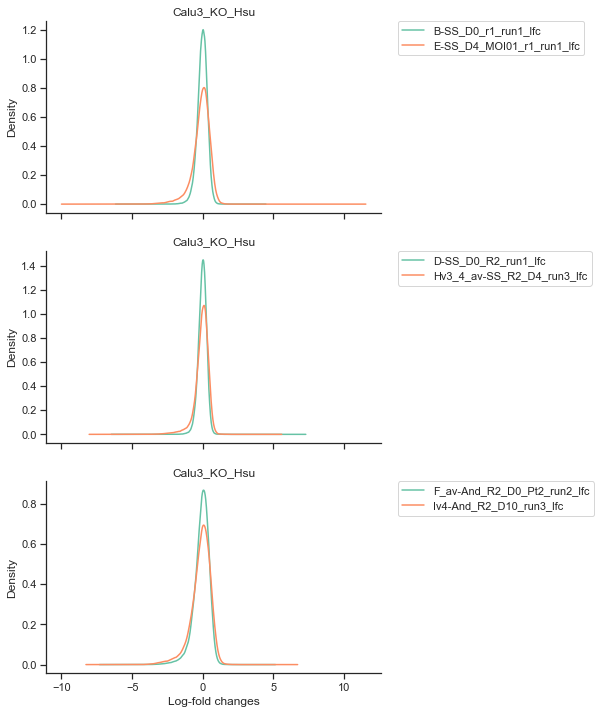

In [6]:
#Calculate log-fold change relative to pDNA
target_cols = list(lognorms.columns[3:])
pDNA_lfc = fns.calculate_lfc(lognorms,target_cols)

# Pair cols 
paired_cols = []
i = 0
j = 0 
for i, t in enumerate(treatment_cols):
    for j ,c in enumerate(control_cols):
        if i == j:
            c_new = c + '_lfc'
            t_new = t + '_lfc'
            pair = [c_new, t_new]
            paired_cols.append(pair)
        else:
            continue
paired_cols = True, paired_cols
        

#Plot population distributions of log-fold changes 
fns.lfc_dist_plot(pDNA_lfc, paired_cols=paired_cols, filename = 'Calu3_KO_Hsu', figsize=(6, 12))

### Control Distributions

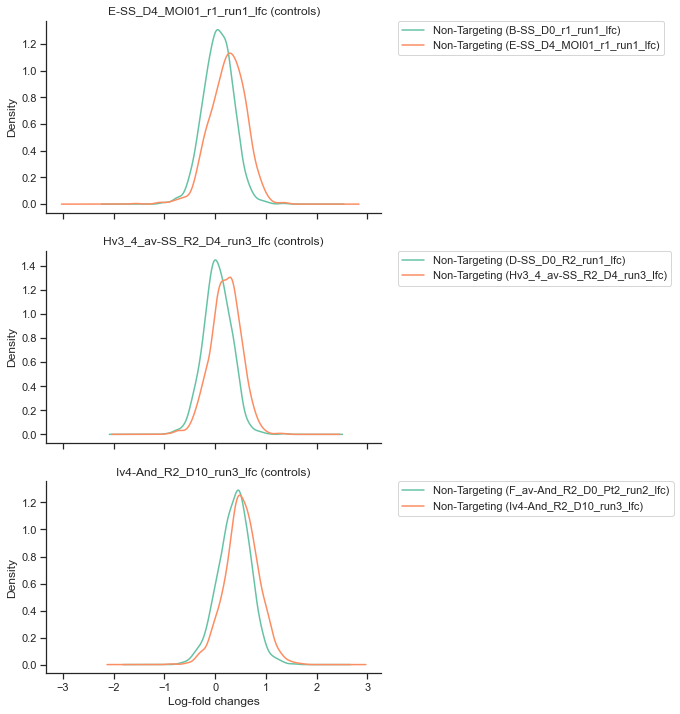

In [18]:
fns.control_dist_plot(pDNA_lfc, paired_cols=paired_cols, control_name=['Non-Targeting'], filename='Calu3_KO_Hsu', figsize=(6, 12))

### ROC-AUC

Text(0, 0.5, 'True Positive Rate (essential)')

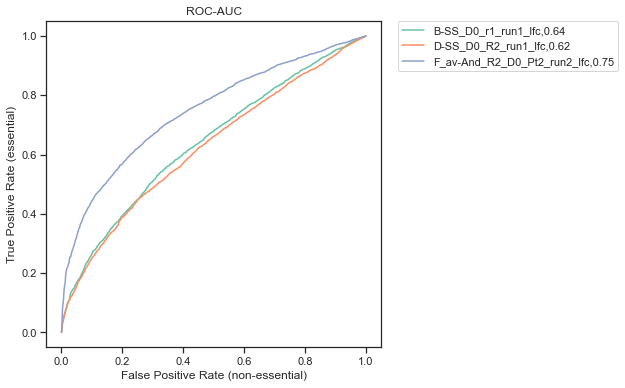

In [19]:
ess_genes, non_ess_genes = fns.get_gene_sets()

tp_genes = ess_genes.loc[:, 'Gene Symbol'].to_list()

fp_genes = non_ess_genes.loc[:, 'Gene Symbol'].to_list()

control_lfc_cols = []

for col in control_cols:
    new_col = col + '_lfc'
    control_lfc_cols.append(new_col)

# control_cols = [col for col in pDNA_lfc.columns if 'control' in col]
control_roc_dict = {}
control_roc_auc_dict = {}
for col in control_lfc_cols:
    roc_auc, roc_df = pool.get_roc_aucs(pDNA_lfc, tp_genes, fp_genes, gene_col = 'Gene Symbol', score_col=col)
    control_roc_dict[col] = roc_df
    control_roc_auc_dict[col] = roc_auc

fig,ax=plt.subplots(figsize=(6,6))

for key, df in control_roc_dict.items():
    roc_auc = control_roc_auc_dict[key]
    ax=sns.lineplot(data=df, x='fpr',y='tpr', ci=None, label = key+',' + str(round(roc_auc,2)))

plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.title('ROC-AUC')
plt.xlabel('False Positive Rate (non-essential)')
plt.ylabel('True Positive Rate (essential)')


## Gene-level analysis

### Residual z-scores

In [20]:
#Calculate z-scores of lfc residuals
lfc_df = pDNA_lfc.copy().drop(['Gene Symbol'], axis = 1)
lfc_df = lfc_df.dropna()
lfc_df = lfc_df.drop_duplicates()
paired_lfc_cols = paired_cols[1]

guide_residuals_lfcs, all_model_info, model_fit_plots = run_guide_residuals(lfc_df, paired_lfc_cols)

guide_mapping = pDNA_lfc[['Guide', 'Gene Symbol']]

gene_residuals = anchors.get_gene_residuals(guide_residuals_lfcs, guide_mapping)


                     modified                  unperturbed
0   E-SS_D4_MOI01_r1_run1_lfc          B-SS_D0_r1_run1_lfc
1  Hv3_4_av-SS_R2_D4_run3_lfc          D-SS_D0_R2_run1_lfc
2     Iv4-And_R2_D10_run3_lfc  F_av-And_R2_D0_Pt2_run2_lfc


In [21]:
gene_residual_sheet = fns.format_gene_residuals(gene_residuals, guide_min=3, guide_max=5)
guide_residual_sheet = pd.merge(guide_mapping, guide_residuals_lfcs, on = 'Guide', how = 'outer')

['Iv4-And_R2_D10_run3_lfc', 'E-SS_D4_MOI01_r1_run1_lfc', 'Hv3_4_av-SS_R2_D4_run3_lfc']
Iv4-And_R2_D10_run3_lfc
E-SS_D4_MOI01_r1_run1_lfc
Hv3_4_av-SS_R2_D4_run3_lfc


In [22]:
with pd.ExcelWriter('../../Data/Processed/GEO_submission_v2/Calu3_KO_Hsu_v1.xlsx') as writer:  
    gene_residual_sheet.to_excel(writer, sheet_name='Calu3_KO_avg_zscore', index =False)
    reads.to_excel(writer, sheet_name='Calu3_KO_genomewide_reads', index =False)
    guide_mapping.to_excel(writer, sheet_name='Calu3_KO_guide_mapping', index =False)

In [23]:
with pd.ExcelWriter('../../Data/Processed/Individual_screens_v2/Calu3_KO_Hsu_indiv1.xlsx') as writer:   
    gene_residuals.to_excel(writer, sheet_name='condition_genomewide_zscore', index =False)
    guide_residual_sheet.to_excel(writer, sheet_name='guide-level_zscore', index =False)

## Compare to Goujon data

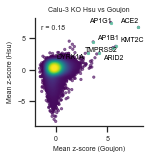

In [24]:
from adjustText import adjust_text

# Read Goujon Gattinara processed data
Goujon_Calu3_Gat = pd.read_excel('../../Data/Processed/GEO_submission_v2/Calu3_Gattinara_Goujon_v2.xlsx')
HsuvsGoujon_Calu3_ko = pd.merge(Goujon_Calu3_Gat, gene_residual_sheet, on = 'Gene Symbol', suffixes = ['_Goujon', '_Hsu'])

fig, ax = plt.subplots(figsize=(2,2))
ax = gpp.point_densityplot(HsuvsGoujon_Calu3_ko, 'residual_zscore_avg_Goujon', 'residual_zscore_avg_Hsu', s=6)


ax = gpp.add_correlation(HsuvsGoujon_Calu3_ko, 'residual_zscore_avg_Goujon', 'residual_zscore_avg_Hsu', loc='upper left', fontsize = 7)
top_ranked_Goujon = HsuvsGoujon_Calu3_ko.nlargest(20, 'residual_zscore_avg_Goujon')
top_ranked_Hsu = HsuvsGoujon_Calu3_ko.nlargest(20, 'residual_zscore_avg_Hsu')
top_ranked_Vero = pd.concat([top_ranked_Goujon, top_ranked_Hsu]).reset_index(drop = True).drop_duplicates()
bottom_ranked_Goujon = HsuvsGoujon_Calu3_ko.nsmallest(20, 'residual_zscore_avg_Goujon')
bottom_ranked_Hsu = HsuvsGoujon_Calu3_ko.nsmallest(20, 'residual_zscore_avg_Hsu')
bottom_ranked_Vero = pd.concat([bottom_ranked_Goujon, bottom_ranked_Hsu]).reset_index(drop = True).drop_duplicates()

ranked_Goujon = pd.concat([top_ranked_Goujon, bottom_ranked_Goujon])
ranked_Hsu = pd.concat([top_ranked_Hsu, bottom_ranked_Hsu])

# Label gene hits common to both screens 
common_ranked_Calu3_ko = pd.merge(ranked_Goujon, ranked_Hsu, on =['Gene Symbol', 'residual_zscore_avg_Goujon', 'residual_zscore_avg_Hsu'], how = 'inner')

# ranked_Vero = pd.concat([top_ranked_Vero, bottom_ranked_Vero])
sns.scatterplot(data = common_ranked_Calu3_ko, x='residual_zscore_avg_Goujon', y='residual_zscore_avg_Hsu', color = sns.color_palette('Set2')[0], edgecolor=None, s=6, rasterized=True)

texts= []
for j, row in common_ranked_Calu3_ko.iterrows():
    texts.append(ax.text(row['residual_zscore_avg_Goujon']+0.25, row['residual_zscore_avg_Hsu'], row['Gene Symbol'], fontsize = 7, 
                                  color = 'black'))
        # ensures text labels are non-overlapping
    adjust_text(texts)
    #texts[j].set_bbox(dict(facecolor='white', alpha=0.75, edgecolor='black'))

plt.title('Calu-3 KO Hsu vs Goujon', fontsize=7)
plt.xlabel('Mean z-score (Goujon)', fontsize=7)
plt.ylabel('Mean z-score (Hsu)', fontsize=7)
plt.xticks(fontsize=7)
plt.yticks(fontsize=7)


# plt.gca().set_aspect('equal', adjustable='box')
ax.set_box_aspect(1)
sns.despine()
gpp.savefig('../../Figures/Scatterplots/Calu3KO_HsuvsGoujon_scatterplot.pdf', dpi=300)
plt.savefig('../../Figures/Scatterplots/Calu3KO_HsuvsGoujon_scatterplot.png', bbox_inches = 'tight')
